<a href="https://colab.research.google.com/github/vieduy/CS114.K21/blob/master/ransac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 142kB/s 
     |████████████████████████████████| 14.5MB 317kB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:


In [1]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

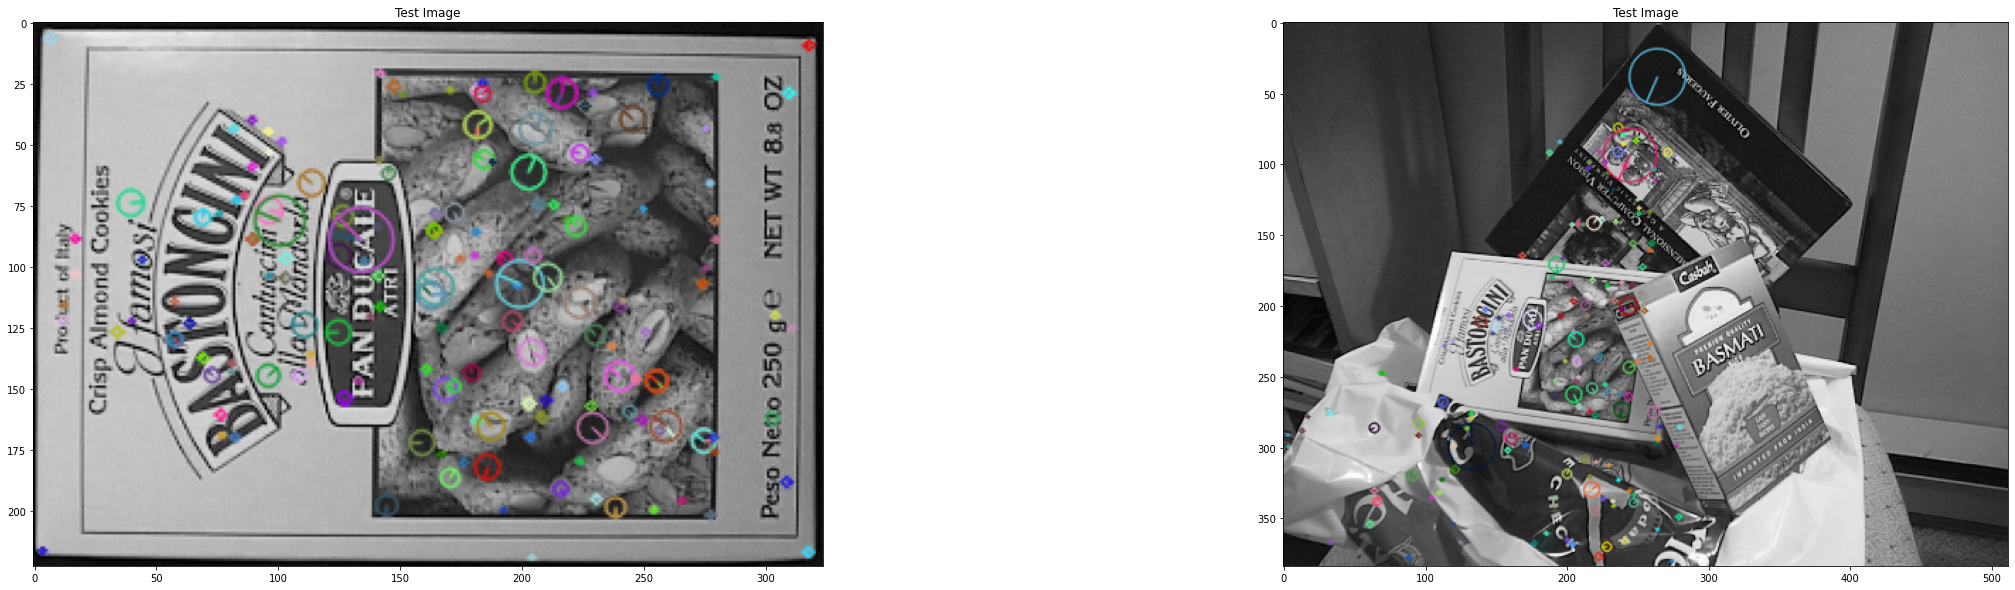

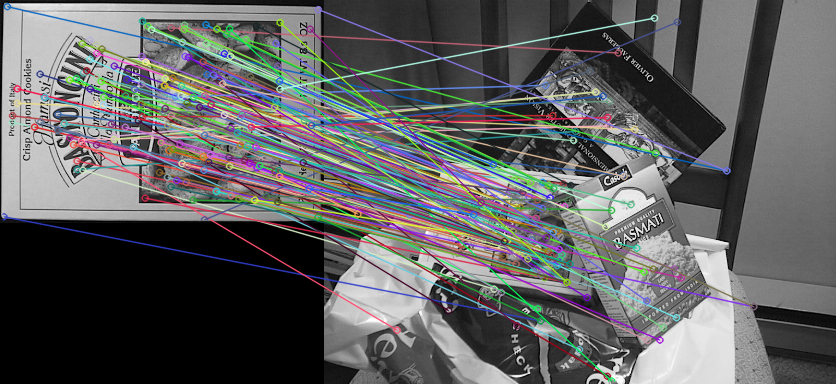

In [17]:
imageTrain = 'box.png'
imageTest = 'box_in_scene.png'

img1 = cv.imread(imageTrain) # trainImage
img2 = cv.imread(imageTest) # test

# Detect keypoints using SIFT feature
sift = cv.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# Display traning image and testing image
vis_point1 = cv.drawKeypoints(img1,kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
vis_point2 = cv.drawKeypoints(img2,kp2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fx, plots = plt.subplots(1, 2, figsize=(40,10))

# plots[0].set_title("Training Image")
# plots[0].imshow(vis_point1)
# plots[1].set_title("Test Image")
# plots[1].imshow(vis_point2)

bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.9*n.distance:
        good.append(m)

src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2) # danh sach toa do cac diem anh train (duoc danh gia la good)
kp1_1 = [ kp1[m.queryIdx] for m in good ]

vis_point1_1 = cv.drawKeypoints(img1,kp1_1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plots[0].set_title("Test Image")
plots[0].imshow(vis_point1_1)

dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2) # danh sach toa do cac diem anh test (tuong ung connect voi train)
kp2_1 = [ kp2[m.queryIdx] for m in good ]
vis_point2_1 = cv.drawKeypoints(img2,kp2_1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plots[1].set_title("Test Image")
plots[1].imshow(vis_point2_1)
plt.show()

# img3 = cv2.drawMatches(img1,kp1_1,img2,kp2_1,good,None)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2_imshow(img3)

# Cai dat thuat toan RANSAC o day


In [24]:
keypoint1 = [[kp1_1[i].pt] for i in range(len(kp1_1))]
keypoint2 = [[kp2_1[i].pt] for i in range(len(kp2_1))]
# print(keypoint2[0])
# print(np.shape(keypoint2))
x, y = np.split(keypoint2, [-1], axis=1)

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math
import sys
 
# Ransac parameters
ransac_iterations = 30  # number of iterations
ransac_threshold = 15    # threshold
ransac_ratio = 0.6      # ratio of inliers required to assert
                        # that a model fits well to data
 
# generate sparse input data
n_samples = 173               # number of input points
outliers_ratio = 0.4          # ratio of outliers
 
n_inputs = 1
n_outputs = 1
 
# # generate samples
# x = 30*np.random.random((n_samples,n_inputs))
 
# # generate line's slope (called here perfect fit)
# perfect_fit = 0.5*np.random.normal(size=(n_inputs,n_outputs) )
 
# # compute output
# y = scipy.dot(x,perfect_fit)

In [ ]:
def find_line_model(points):
    """ find a line model for the given points
    :param points selected points for model fitting
    :return line model
    """
 
    # [WARNING] vertical and horizontal lines should be treated differently
    #           here we just add some noise to avoid division by zero
 
    # find a line model for these points
    m = (points[1,1] - points[0,1]) / (points[1,0] - points[0,0] + sys.float_info.epsilon)  # slope (gradient) of the line
    c = points[1,1] - m * points[1,0]                                     # y-intercept of the line
 
    return m, c

In [ ]:
def find_intercept_point(m, c, x0, y0):
    """ find an intercept point of the line model with
        a normal from point (x0,y0) to it
    :param m slope of the line model
    :param c y-intercept of the line model
    :param x0 point's x coordinate
    :param y0 point's y coordinate
    :return intercept point
    """
 
    # intersection point with the model
    x = (x0 + m*y0 - m*c)/(1 + m**2)
    y = (m*x0 + (m**2)*y0 - (m**2)*c)/(1 + m**2) + c
 
    return x, y

In [ ]:
def ransac_plot(n, x, y, m, c, final=False, x_in=(), y_in=(), points=()):
    """ plot the current RANSAC step
    :param n      iteration
    :param points picked up points for modeling
    :param x      samples x
    :param y      samples y
    :param m      slope of the line model
    :param c      shift of the line model
    :param x_in   inliers x
    :param y_in   inliers y
    """
 
    fname = "output/figure_" + str(n) + ".png"
    line_width = 1.
    line_color = '#0080ff'
    title = 'iteration ' + str(n)
 
    if final:
        fname = "output/final.png"
        line_width = 3.
        line_color = '#ff0000'
        title = 'final solution'
 
    plt.figure("Ransac", figsize=(15., 15.))
 
    # grid for the plot
    grid = [min(x) - 10, max(x) + 10, min(y) - 20, max(y) + 20]
    plt.axis(grid)
 
    # put grid on the plot
    plt.grid(b=True, which='major', color='0.75', linestyle='--')
    plt.xticks([i for i in range(int(min(x)[0]) - 10, int(max(x)[0]) + 10, 5)])
    plt.yticks([i for i in range(int(min(y)[0]) - 20, int(max(y)[0] + 20), 10)])
 
    # plot input points
    plt.plot(x[:,0], y[:,0], marker='o', label='Input points', color='#00cc00', linestyle='None', alpha=0.4)
 
    # draw the current model
    plt.plot(x, m*x + c, 'r', label='Line model', color=line_color, linewidth=line_width)
 
    # draw inliers
    if not final:
        plt.plot(x_in, y_in, marker='o', label='Inliers', linestyle='None', color='#ff0000', alpha=0.6)
 
    # draw points picked up for the modeling
    if not final:
        plt.plot(points[:,0], points[:,1], marker='o', label='Picked points', color='#0000cc', linestyle='None', alpha=0.6)
 
    plt.title(title)
    plt.legend()
    plt.savefig(fname)
    plt.close()

In [ ]:
data = np.hstack((x,y))
 
ratio = 0.
model_m = 0.
model_c = 0.
 
# perform RANSAC iterations
for it in range(ransac_iterations):
 
    # pick up two random points
    n = 2
 
    all_indices = np.arange(x.shape[0])
    np.random.shuffle(all_indices)
 
    indices_1 = all_indices[:n]
    indices_2 = all_indices[n:]
 
    maybe_points = data[indices_1,:]
    test_points = data[indices_2,:]
 
    # find a line model for these points
    m, c = find_line_model(maybe_points)
 
    x_list = []
    y_list = []
    num = 0
 
    # find orthogonal lines to the model for all testing points
    for ind in range(test_points.shape[0]):
 
        x0 = test_points[ind,0]
        y0 = test_points[ind,1]
 
        # find an intercept point of the model with a normal from point (x0,y0)
        x1, y1 = find_intercept_point(m, c, x0, y0)
 
        # distance from point to the model
        dist = math.sqrt((x1 - x0)**2 + (y1 - y0)**2)
 
        # check whether it's an inlier or not
        if dist < ransac_threshold:
            x_list.append(x0)
            y_list.append(y0)
            num += 1
 
    x_inliers = np.array(x_list)
    y_inliers = np.array(y_list)
 
    # in case a new model is better - cache it
    if num/float(n_samples) > ratio:
        ratio = num/float(n_samples)
        model_m = m
        model_c = c
 
    # print '  inlier ratio = ', num/float(n_samples)
    # print '  model_m = ', model_m
    # print '  model_c = ', model_c
 
    # plot the current step
    ransac_plot(it ,x ,y , m, c, False, x_inliers, y_inliers, maybe_points)
 
    # we are done in case we have enough inliers
    if num > n_samples*ransac_ratio:
        print('The model is found !')
        break
 
# plot the final model
ransac_plot(0,x, y, model_m, model_c, True)
 
# print '\nFinal model:\n'
# print '  ratio = ', ratio
# print '  model_m = ', model_m
# print '  model_c = ', model_c

In [ ]:
print(len(x_inliers))

49


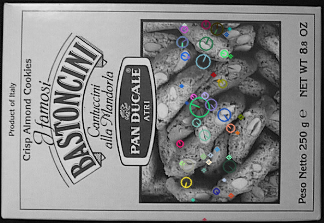

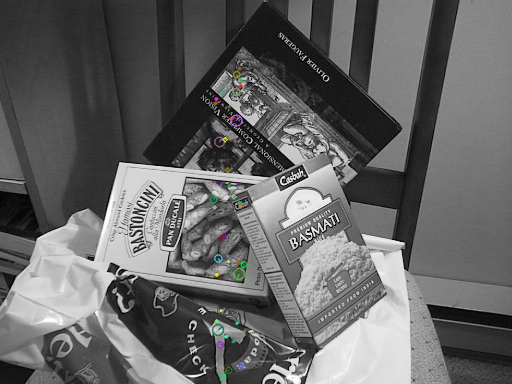

In [ ]:
indexs = []
for x_inlier in x_inliers:
  indexs.extend(np.where(x==x_inlier)[0])

indexs = np.unique(indexs)

kp1_11 = (np.array(kp1_1)[indexs])
kp2_11 = np.array(kp2_1)[indexs]
img = cv.drawKeypoints(img1,kp1_11, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_2 = cv.drawKeypoints(img2,kp2_11, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2_imshow(img)
cv2_imshow(img_2)

In [5]:
img1 = cv.imread('1.jpg') # trainImage
img2 = cv.imread('2.jpg') # test

ret1, corners1 = cv2.findChessboardCorners(img1, (9, 6))
ret2, corners2 = cv2.findChessboardCorners(img2, (9, 6))

In [26]:
print(corners2.shape)

(54, 1, 2)


In [25]:
print(np.shape(keypoint1))

(173, 1, 2)


In [55]:
H, _ = cv.findHomography(np.array(keypoint1[21:25]), np.array(keypoint2[21:25]))
print(H)

[[-1.22083467e+00 -1.41762530e-01  1.18909301e+02]
 [-2.98058127e+00 -3.54429986e-01  2.91347488e+02]
 [-1.02832067e-02 -1.18282205e-03  1.00000000e+00]]


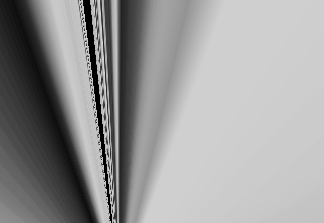

In [56]:
img1_warp = cv.warpPerspective(img1, H, (img1.shape[1], img1.shape[0]))
cv2_imshow(img1_warp)